## Install libraries

In [2]:
import sys
!{sys.executable} -m pip install sklearn tensorflow tensorflow_text tensorflow_decision_forests pandas seaborn tqdm matplotlib numpy pandas

Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 5.0/5.0 MB 868.3 kB/s eta 0:00:00


ERROR: Could not find a version that satisfies the requirement tensorflow_decision_forests (from versions: none)
ERROR: No matching distribution found for tensorflow_decision_forests


## Initial imports

In [1]:
# General imports
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
from tqdm.auto import tqdm
# Enable progress bar for operations on pandas dataframes
tqdm.pandas()

# Better image quality
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

## Basic dataset manipulation

In [7]:
# Let's load the data and convert the attributes `Sentence` to str
train_df = pd.read_csv('./sql_train.csv')
valid_df = pd.read_csv('./sql_val.csv')
test_df  = pd.read_csv('./sql_test.csv')

train_df['Sentence'] = train_df['Sentence'].apply(lambda x: str(x))
valid_df['Sentence'] = valid_df['Sentence'].apply(lambda x: str(x))
test_df['Sentence']  = test_df['Sentence'].apply( lambda x: str(x))

In [8]:
# The `test_df` contains only the features (we need to predict the labels)
print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:",  test_df.shape)

Train: (45288, 2)
Valid: (5661, 2)
Test: (5661, 1)


In [9]:
train_df.head(3)

,Sentence,Label
0,1'+ ( select 'vedi' where 2774 = 2774 and 9660...,1
1,"1' in boolean mode ) union all select null,nu...",1
2,t16564l,0


In [10]:
valid_df.head(3)

,Sentence,Label
0,98089077b,0
1,"1%"" ) waitfor delay '0:0:5'--",1
2,08589,0


In [11]:
test_df.head(3)

,Sentence
0,49830
1,"1"" ) ) ) union all select null--"
2,"1 ) union all select null,null,null,null,null..."


In [12]:
train_df.dtypes

Sentence    object
Label        int64
dtype: object

In [13]:
# Clean (0) and dirty (1) samples in the `train_df`
train_df[train_df['Label'] == 0].shape[0], train_df[train_df['Label'] == 1].shape[0]

(27380, 17908)

In [14]:
valid_df[valid_df['Label'] == 0].shape[0], valid_df[valid_df['Label'] == 1].shape[0]

(3519, 2142)

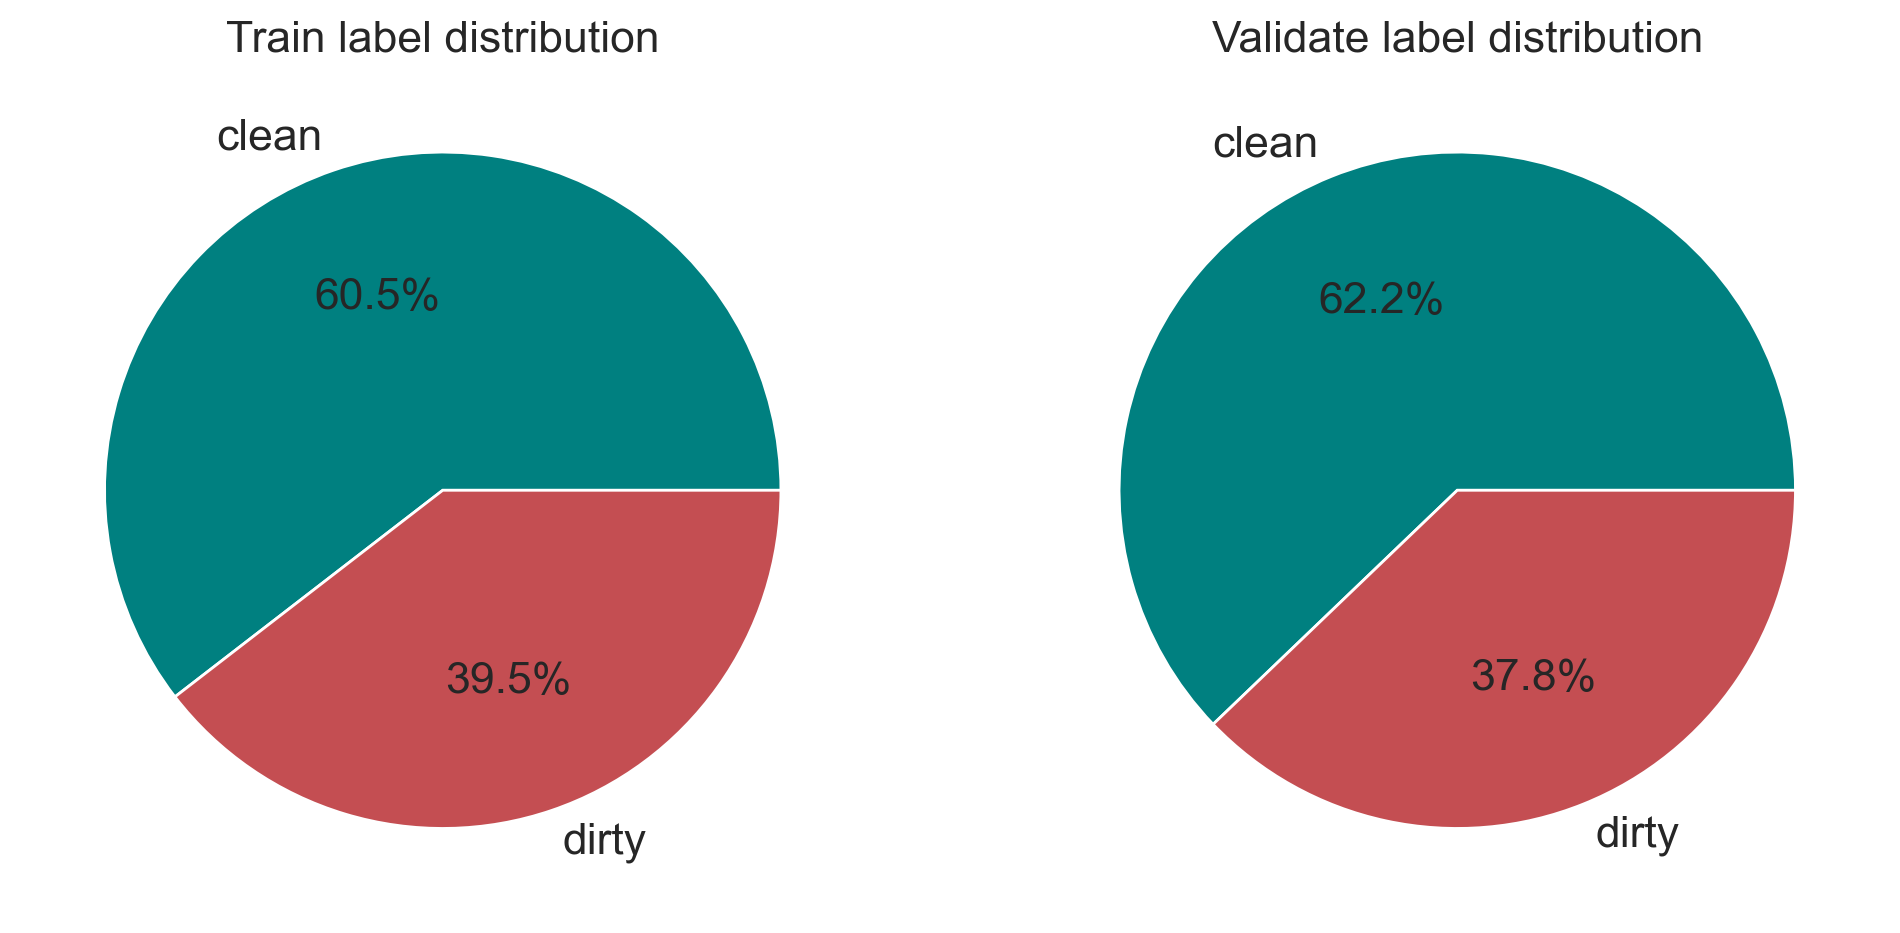

In [15]:
# We can also plot a pie chart of label distribution for each dataframe
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(
    train_df['Label'].value_counts().to_list(), 
    labels=['clean', 'dirty'], colors=['teal', 'r'],
    autopct='%1.1f%%', textprops={'fontsize': 16}
)
plt.title('Train label distribution', fontsize=16)

plt.subplot(1, 2, 2)
plt.pie(
    valid_df['Label'].value_counts().to_list(), 
    labels=['clean', 'dirty'], colors=['teal', 'r'], 
    autopct='%1.1f%%', textprops={'fontsize': 16}
)
plt.title('Validate label distribution', fontsize=16)

pass

In [16]:
# 2 things to mention here:
# (+) The data is splitted well ~(60%, 40%) inside the training and validation sets
# (-) We have a majority class (clean - 60% vs malicious - 40%)
#     This thing will lead to unbalanced dataset (not a big unbalancing in our cas),
#     which can cause some problems at generalizing. We can solve this problem by:
#         - augmenting some dirty SQL commands
#         - using only 40% of the clean SQL commands
#         - choosing some weights when training the model (e.g.: [0.4, 0.6])
#         - letting the model to learn patterns with this data (because the data is not "very unbalanced")

## Alphabet

In [17]:
# Let's create an alphabet for our training dataset in order to see how many unique characters are
from functools import reduce

# Get a set of chars for each SQL command
xs = train_df['Sentence'].apply(set)

# Perform the union of all these sets and sort them
unique_chars = reduce(set.union, xs)
unique_chars = sorted(unique_chars, key=ord)

# Print the unique characters
print(f"There are {len(unique_chars)} unique chars.")
print(unique_chars)

There are 127 unique chars.
['\x18', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '~', '\x80', '\x98', '\xa0', '£', '½', 'Ã', 'ß', 'â', 'ä', 'ö', 'ü', '—', '‘', '’', '“', '”', '거', '길', '나', '난', '다', '동', '리', '멋', '빠', '요', '있', '주', '추', '트', '하', '홍']


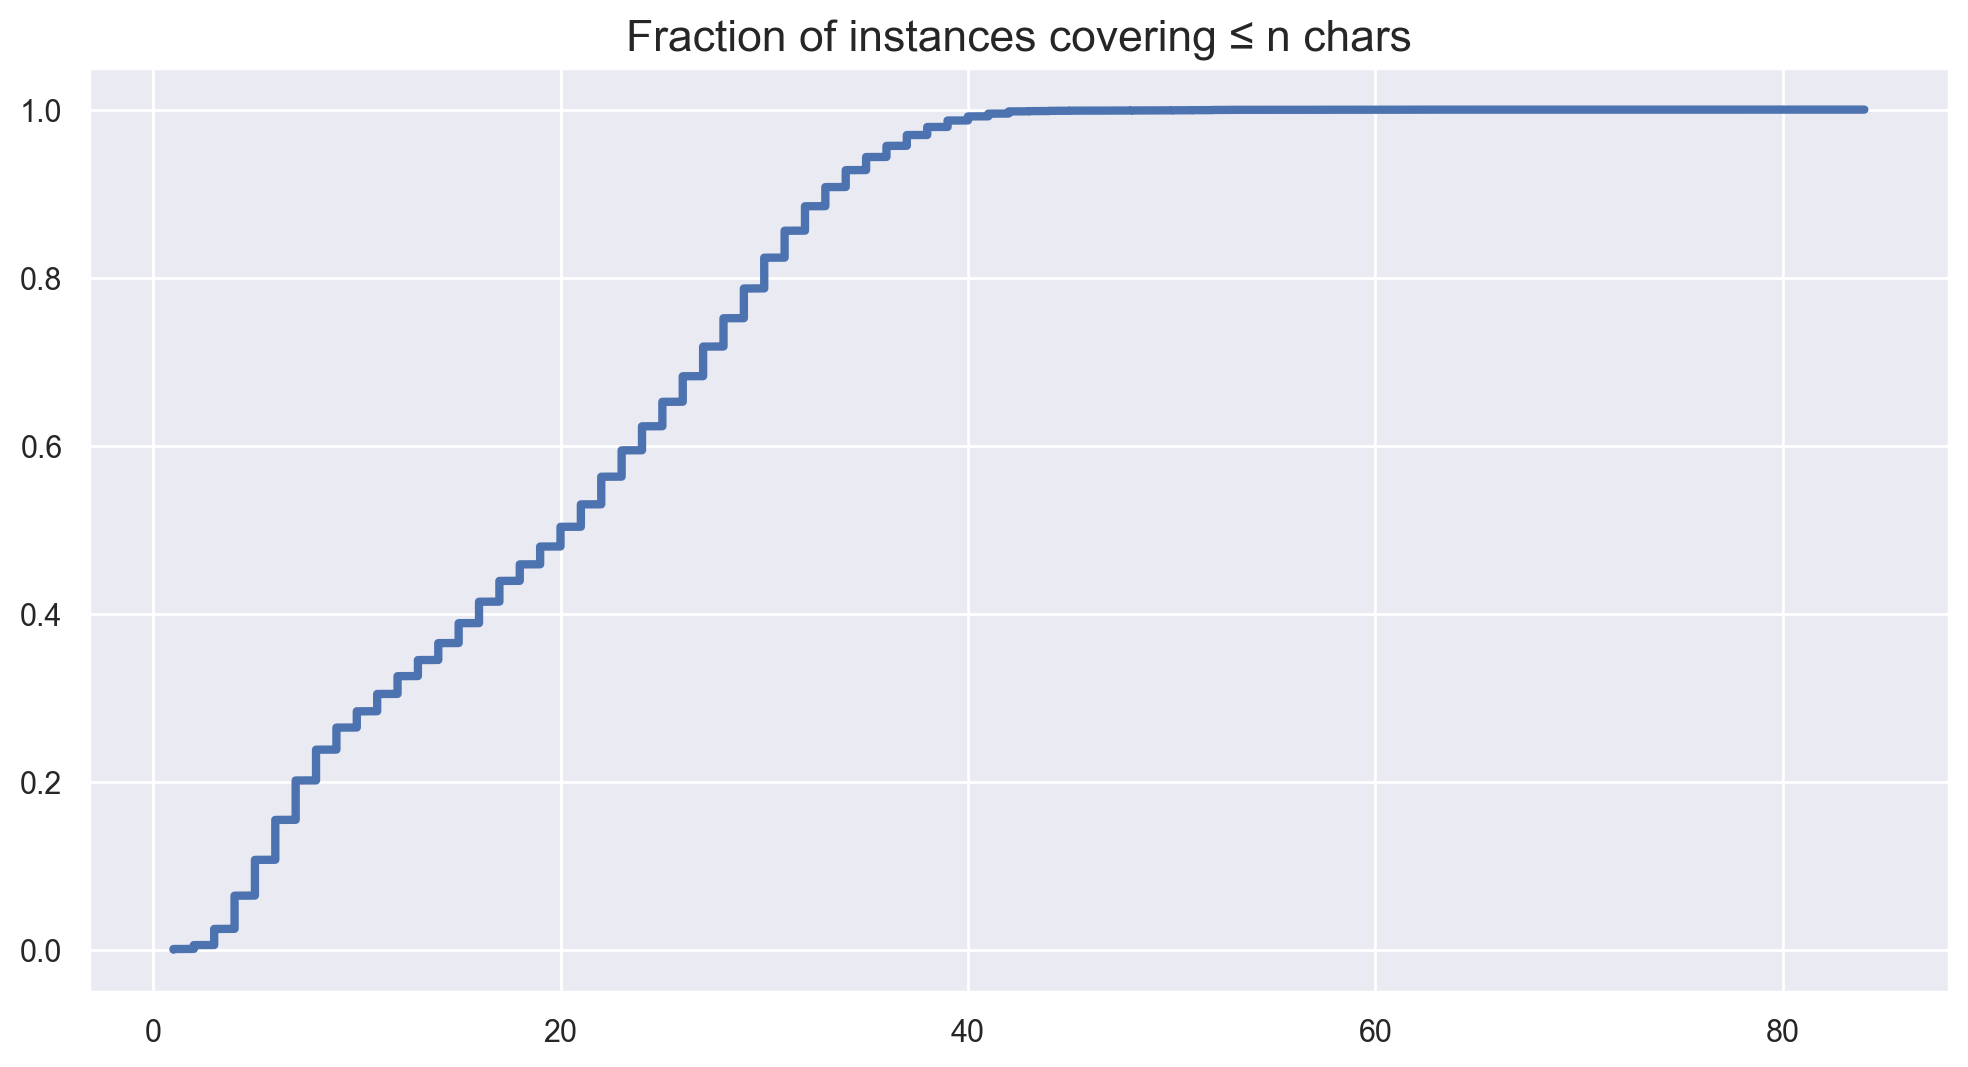

In [18]:
x = np.sort(train_df['Sentence'].apply(lambda x: len(set(x) & set(unique_chars))))
y = np.linspace(0, 1, len(x), endpoint=False)

plt.figure(figsize=(12, 6))
plt.plot(x, y, lw=3)
plt.title("Fraction of instances covering ≤ n chars", fontsize=16)
pass

# As we can see, if we choose the most common ~40 chars, we will cover almost all instances

## Input length

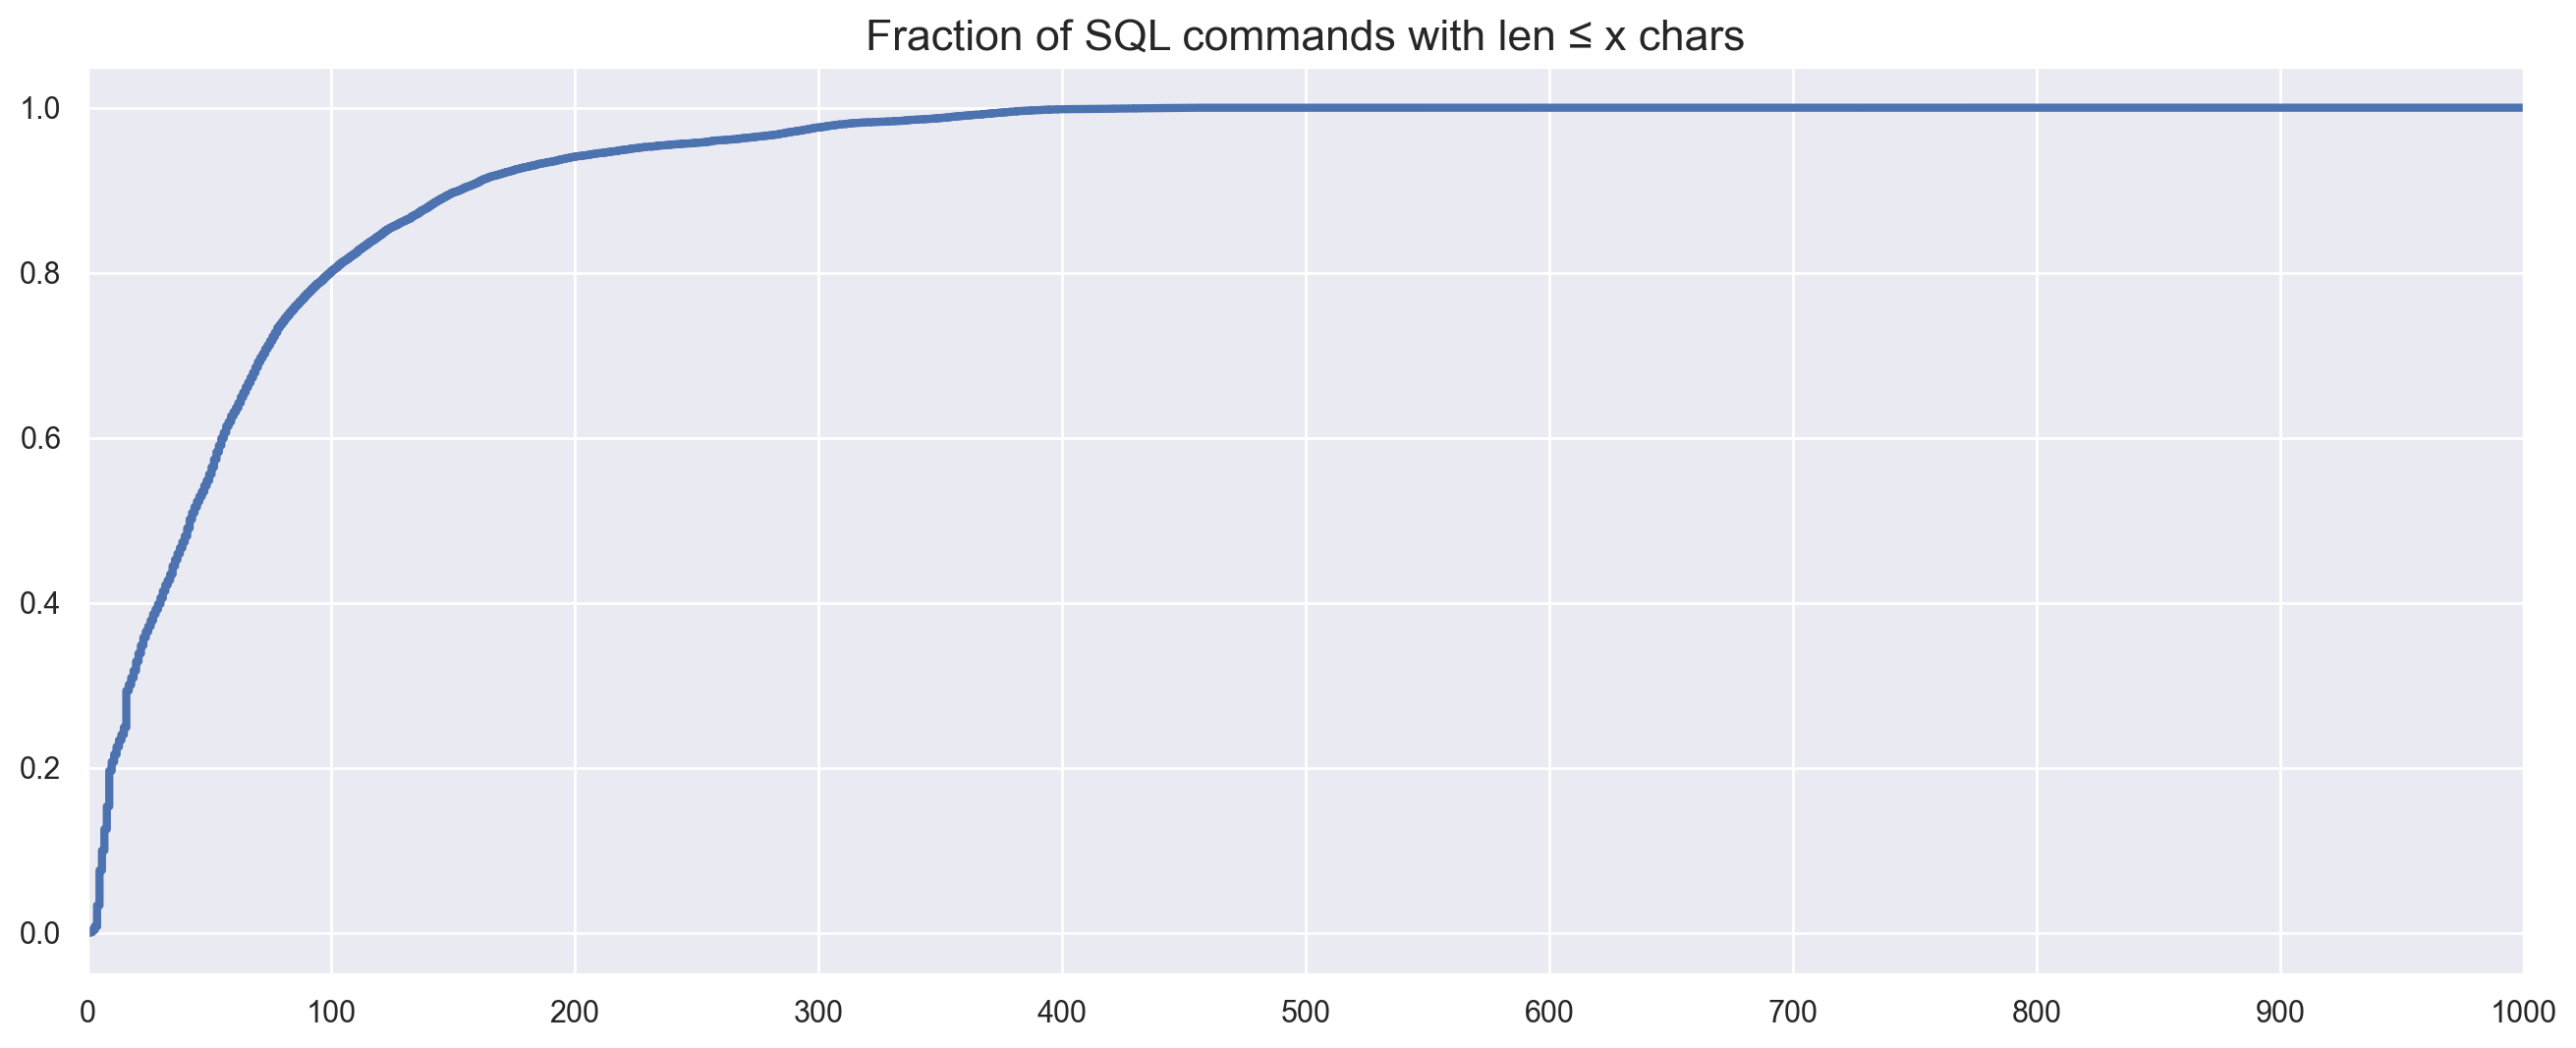

In [19]:
# Let's also plot a cumulative distribution to understand the fraction of examples that have SQL command len <= x
plt.figure(figsize=(16, 6))

x = np.sort(train_df['Sentence'].apply(len))
y = np.linspace(0, 1, len(x), endpoint=False)
plt.plot(x, y, lw=3)
plt.xticks(np.arange(0, x.max(), 100))
plt.xlim([0, 1000])

plt.title('Fraction of SQL commands with len ≤ x chars', fontsize=16)
pass

# From the plot below, we can conclude that almost all SQL commands are shorter than ~400 chars

## Char frequency

In [20]:
from collections import Counter

# Construct char counters for each label
char_counter = {
    0: Counter(),
    1: Counter()
}

# For each label and for each sql command, update the corresponding counter
for i in [0, 1]:
    sqls = train_df.loc[train_df['Label'] == i, 'Sentence'].to_list()
    for sql in sqls:
        char_counter[i].update(sql)

# Top-10 most common clean/dirty chars
print("Label 0 (clean)")
print(char_counter[0].most_common()[:10])
print("Label 1 (dirty)")
print(char_counter[1].most_common()[:10])

# This statistic is interesting, but we can't extract any special insights from it

Label 0 (clean)
[(' ', 140549), ('e', 59426), ('a', 44969), ('r', 37490), ('o', 35963), ('E', 35858), ('t', 34138), ('s', 33516), ('i', 33515), ('n', 31951)]
Label 1 (dirty)
[(' ', 642035), ('e', 93552), (')', 72578), ('1', 70601), ('s', 67314), ('(', 64343), ('r', 59098), ('l', 58392), ('a', 55448), ('c', 50806)]


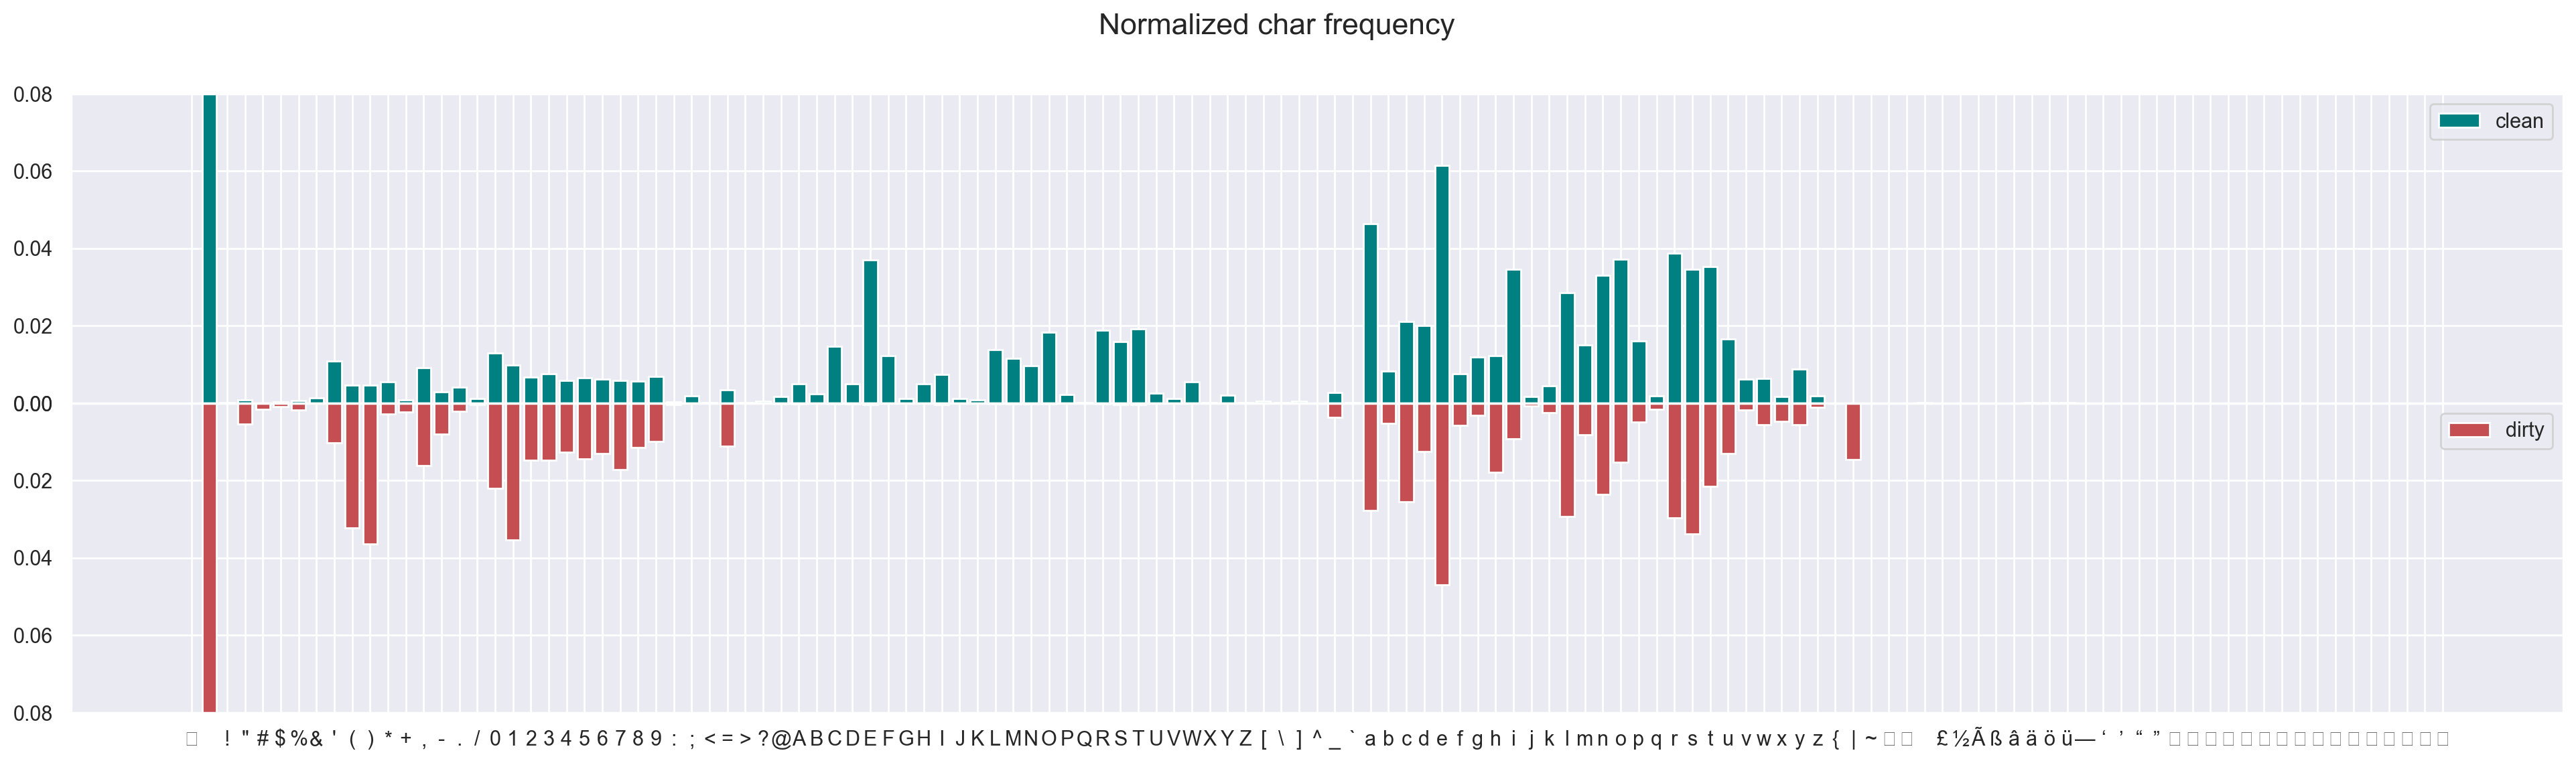

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(24, 6))
plt.suptitle('Normalized char frequency', fontsize=16)

ax1, ax2 = axes.ravel()
ix = np.arange(len(unique_chars))

for i, ax in enumerate(axes.ravel()):
    total_occurrences = sum(char_counter[i].values())
    occurrences_array = np.array(
        [char_counter[i][c] / total_occurrences for c in unique_chars]
    )
    ax.bar(
        ix, occurrences_array, 
        color=['teal', 'r'][i],
        label=['clean', 'dirty'][i]
    )
    ax.set_ylim([0, 0.08])

ax1, ax2 = axes.ravel()
ax2.invert_yaxis()

plt.xticks(ix, labels=unique_chars)

plt.subplots_adjust(hspace=0)

ax1.legend()
ax2.legend()
pass

In [22]:
# An interesting thing we can see is that the uppercase characters (A-Z)
# are not present in the dirty samples (or there are very few compared to the the clean ones) 

## SQL commands length distribution

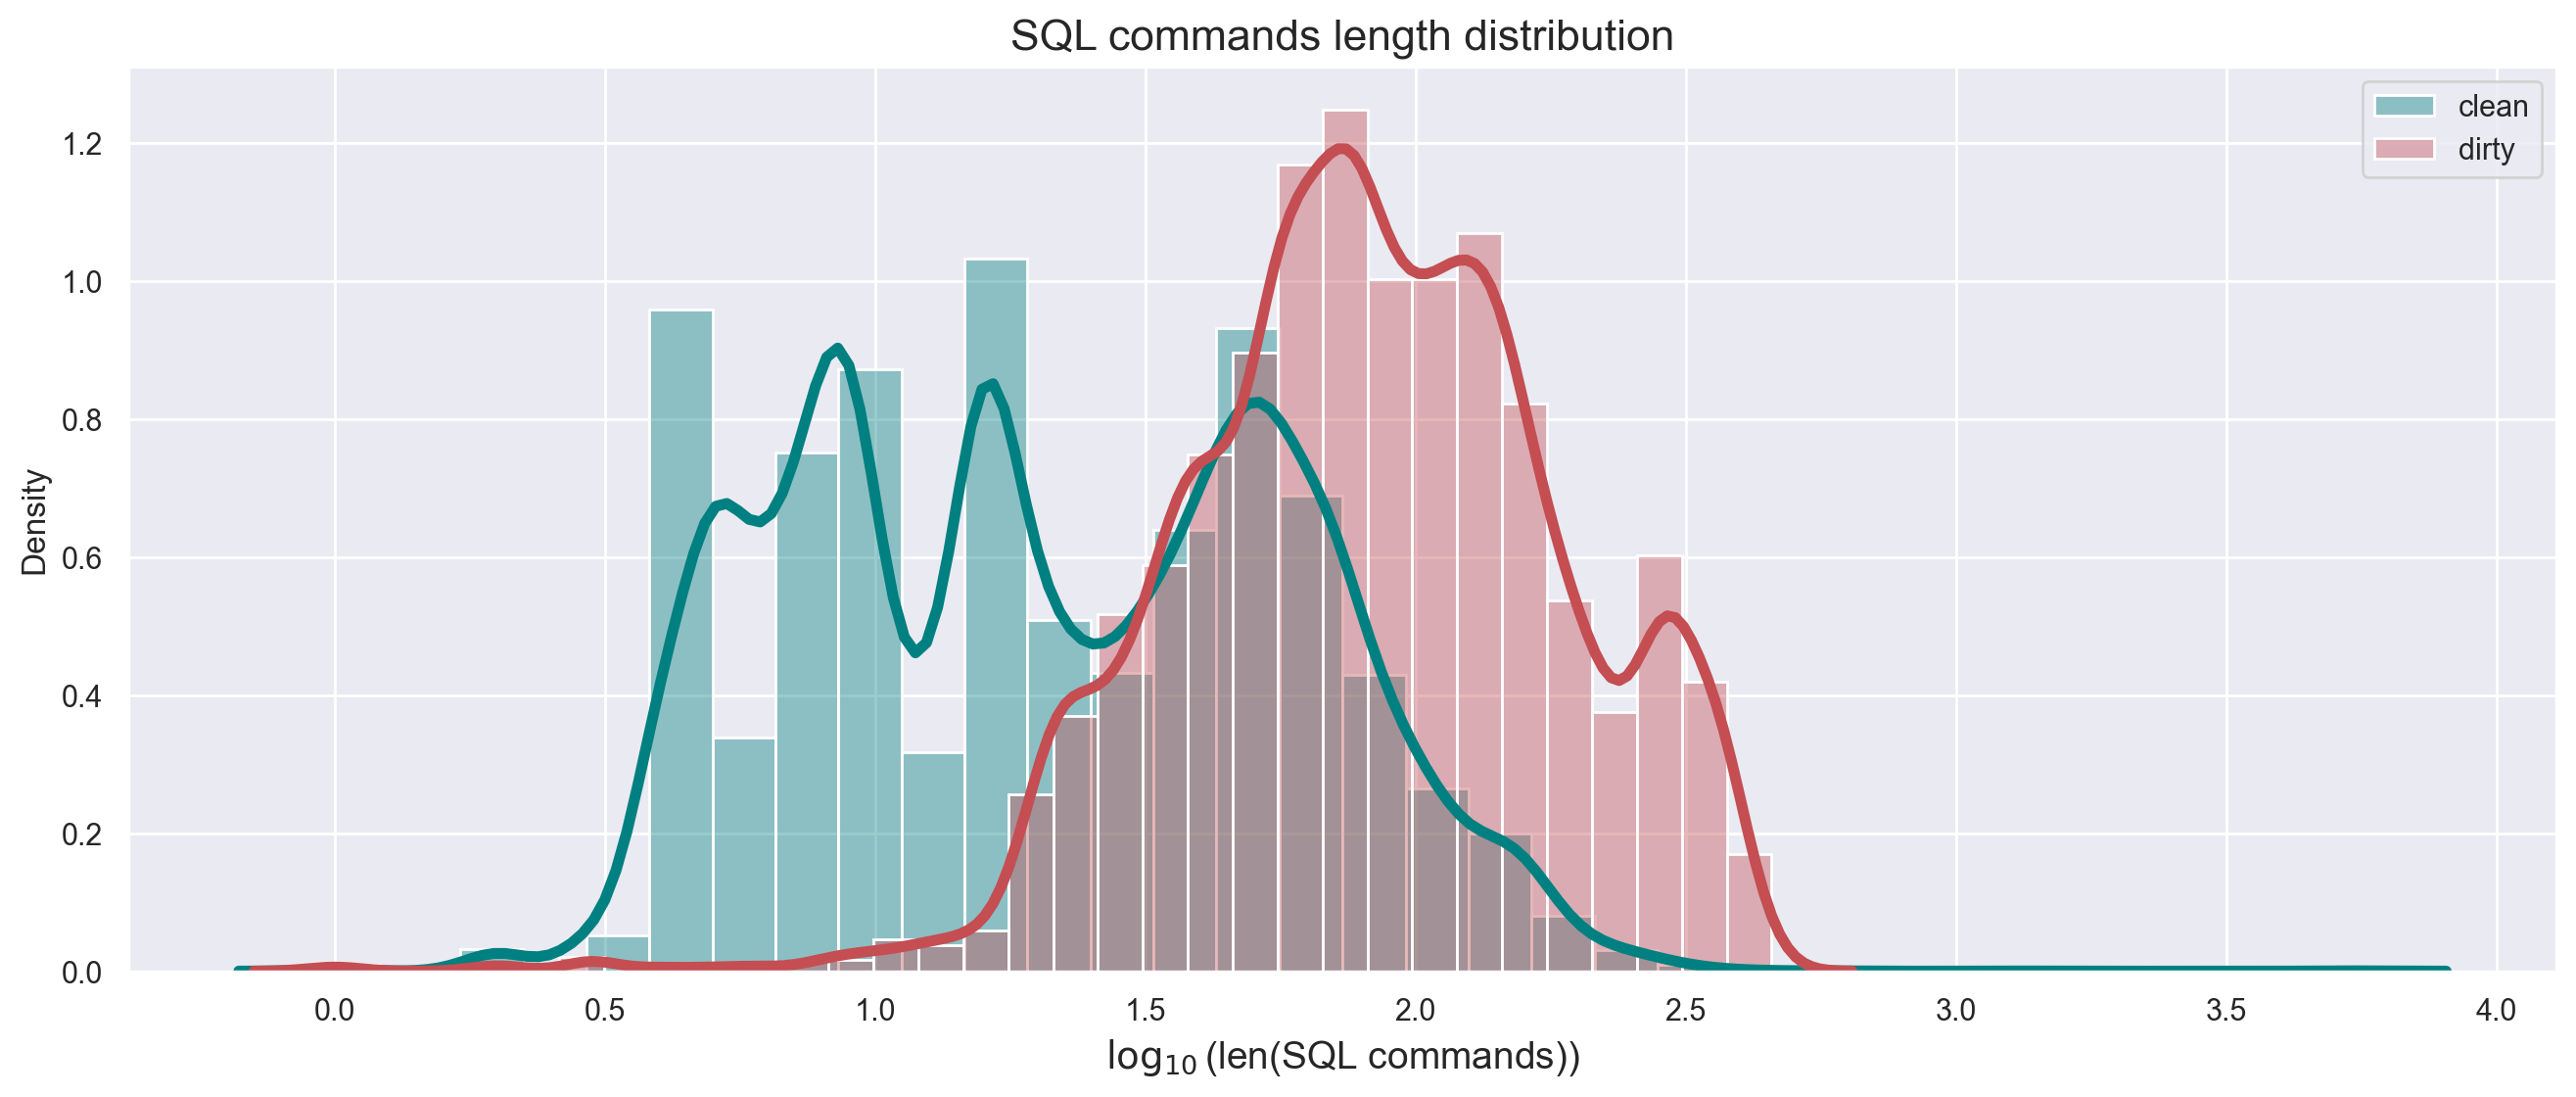

In [23]:
# Let's look at the SQL commands length distribution
plt.figure(figsize=(16, 6))

bins = 32

for i in [0, 1]:
    # log10 because we want to observe order of magnitude (not the value itself)
    lengths = train_df.loc[train_df['Label'] == i, 'Sentence'].apply(lambda x: np.log10(len(x)))

    color = ['teal', 'r'][i]
    sns.histplot(
        lengths, stat='density', bins=bins,
        alpha=0.4, 
        color=color,
        label=['clean', 'dirty'][i]
    )
    sns.kdeplot(lengths, lw=4, color=color)

plt.title('SQL commands length distribution', fontsize=16)
plt.xlabel('$\log_{10}$(len(SQL commands))', fontsize=14)
plt.legend()
pass

In [21]:
# Nice, one thing we can mention here is the fact that longer SQL commands are usually labeled as being dirty
# That means truncating the SQL commands to a lower value may not perform very well

# We can also perform some truncation for fixing the size of the input (for the model),
# and see which model performs better (see if truncating the SQL commands at 800 makes a good improvement compared to 400, for example)

# The SQL commands labeled as dirty tend to be more compact (like a Gaussian distribution), while the clean commands are more spread out

## Weird characters

In [24]:
alphabet = unique_chars
print(alphabet)

['\x18', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '~', '\x80', '\x98', '\xa0', '£', '½', 'Ã', 'ß', 'â', 'ä', 'ö', 'ü', '—', '‘', '’', '“', '”', '거', '길', '나', '난', '다', '동', '리', '멋', '빠', '요', '있', '주', '추', '트', '하', '홍']


In [23]:
# The alphabet also contains some special characters (e.g.: 'ß', '리', '멋', 'ä', '빠')
# which can or cannot (*spoiler*) be representative for the positive class
# Normally, in a clean SQL command (or in production SQL code) is nearly impossible
# to see these strange characters... we will see :)
# Let's plot the distribution of these "special" characters, based on the labels

In [25]:
weird_chars = ['거', '길', '나', '난', '다', '동', '리', '멋', '빠', '요', '있',
               '주', '추', '트', '하', '홍', '½', 'Ã', 'ß', 'â', 'ä', 'ö', 'ü']

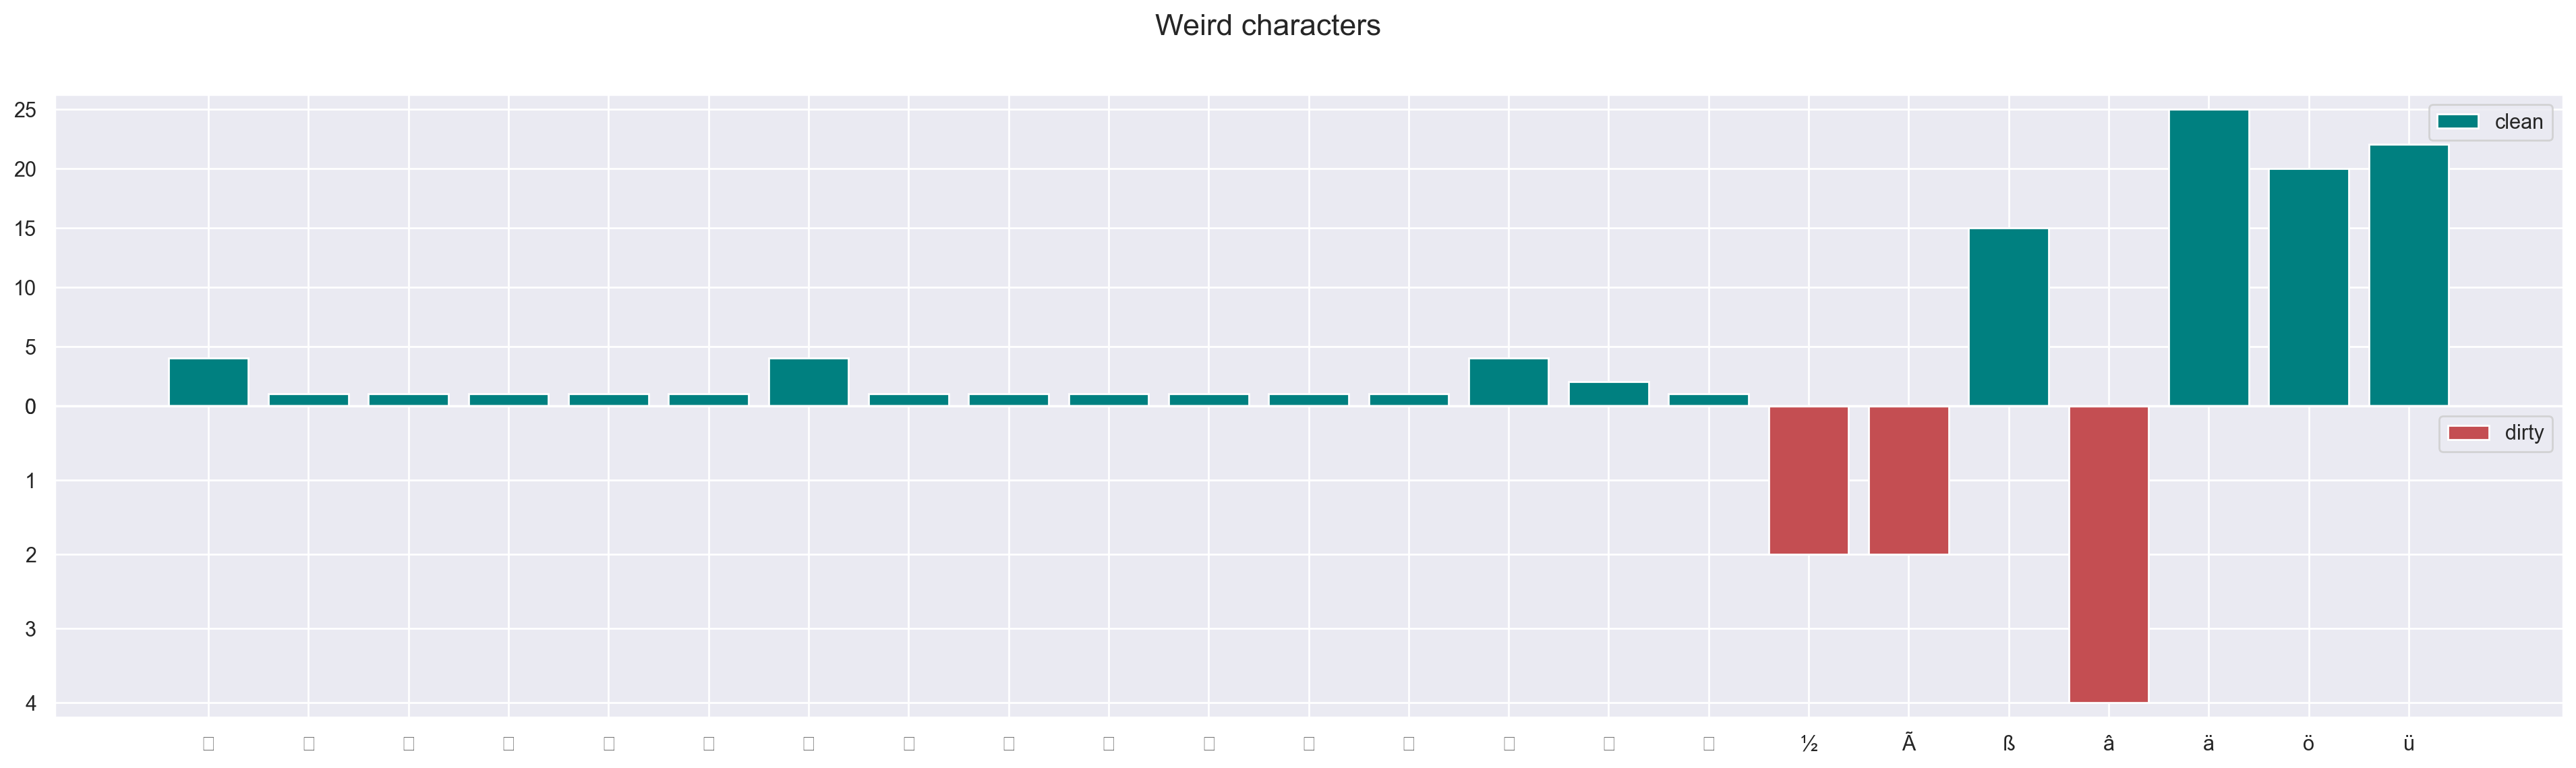

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(24, 6))
plt.suptitle('Weird characters', fontsize=16)

ax1, ax2 = axes.ravel()
ix = np.arange(len(weird_chars))

for i, ax in enumerate(axes.ravel()):
    occurrences_array = np.array([char_counter[i][c] for c in weird_chars])
    ax.bar(
        ix, occurrences_array, 
        color=['teal', 'r'][i],
        label=['clean', 'dirty'][i]
    )

ax1, ax2 = axes.ravel()
ax2.invert_yaxis()

plt.xticks(ix, labels=weird_chars)

plt.subplots_adjust(hspace=0)

ax1.legend()
ax2.legend()
pass

In [26]:
# Oh, there are only a few "special" characters in the positive class. Unexpected, right?
# Let's see how it looks a SQL command which contains this weird character '거' 

In [27]:
train_df[train_df['Sentence'].str.contains('거')]

,Sentence,Label
37320,de]]> </email_address> <find_account_answer...,0
42287,de]]> </email_address> <find_account_answer...,0


In [28]:
# Looks like it's only parsed in this way (maybe for smaller size) and it's not a malicious SQL command

In [29]:
# We can also observe that these characters have a low frequency in the dataset
# We can easily exclude them from the alphabet if we will encounter problems with the training time
# For now, let's use the whole `alphabet` and see what are the results

## Dataset encoding

In [30]:
# I will encode each character as an integer from the dictionary, because this is the desired input
# for the model I am using (CharCNN - Zhang et al. - https://arxiv.org/pdf/1509.01626v3.pdf) (see subsection 2.2)
# We can also encode them as one-hot vectors, but I want to use the entire alphabet (127 characters) and that's
# too much for performing one hot encoding (max 50 characters is a good threshold for one-hot encodings, I would say).

In [31]:
# Therefore, I will encode the SQL sentences as indices from the alphabet

In [29]:
from collections import defaultdict
from typing import List, Optional, Tuple

class SQLDataset:
    # "padding" and "unknown" special tokens
    # <pad> is used to denote "empty" space for cases when the sql command len < input length
    # <unk> is used to denote unknown chars, out of our alphabet
    reserved_tokens = ["<pad>", "<unk>"]

    def __init__(self, df: pd.DataFrame, alphabet: List[str], input_length: int):
        """
        Wrapper class over a dataframe `df` containing SQL commands and labels.
        Provides methods for conversion to and from indices, 
        preparing the vectors used for the model input.
        """
        self.df = df
        self.alphabet = alphabet
        self.input_length = input_length

        # We're using `defaultdict` here so that we have a default value if a key is not present
        self.char2idx = defaultdict(lambda: self.reserved_tokens.index("<unk>"))
        self.idx2char = defaultdict(lambda: "<unk>")

        # Populate mappings for both reserved tokens & alphabet (2 + 127 in our case)
        for idx, char in enumerate(self.reserved_tokens + alphabet):
            self.char2idx[char] = idx
            self.idx2char[idx] = char

    @property
    def input_dim(self):
        """
        The size of the vocabulary, including reserved tokens
        """
        return len(self.char2idx)
    

    def sql_to_indices(self, sql: str) -> np.ndarray:
        """
        Given an SQL command string, construct the corresponding indices array.
        """

        # Construct an output numpy array of zeros (the index of our <pad> token)
        # of size self.input_length
        indices = np.zeros(self.input_length, dtype=np.int32)

        # Take the first self.input_length chars from the sql command
        # and populate the indices array accordingly
        # i.e. indices[i] should have the corresponding index of the char at position i
        for i in range(min(len(sql), self.input_length)):
            char = sql[i]
            indices[i] = self.char2idx[char]

        return indices

    
    def indices_to_sql(self, indices: np.ndarray) -> str:
        """
        Given an indices array, construct the corresponding SQL command string.
        """

        # Output sql command string
        sql = ""

        # Iterate through indices and get back the original char corresponding
        # to a given index, appending it to the output sql string.
        # When encountering the reserved <pad> token, break out of the loop,
        # since no more "interesting" chars will follow.
        for i in indices:
            char = self.idx2char[i]

            if char == "<pad>":
                break

            sql += char

        return sql
    

    def prepare_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Prepare data for training. Return a tuple of 2 numpy arrays: (indices, labels).
        """

        # Apply the self.sql_to_indices function for each sql in the input dataframe self.df
        # Convert the output to a numpy array with `.to_numpy()`
        # Finally, do a vertical stack of all these arrays to obtain an output array of shape
        # (len(df) rows, input_length cols)
        indices = np.vstack(self.df['Sentence'].progress_apply(self.sql_to_indices).to_numpy())

        # Get a numpy array of labels from the dataframe
        labels = self.df['Label'].to_numpy()

        return indices, labels

    def prepare_test_data(self) -> np.ndarray:
        """
        Prepare data for testing. Return only 1 numpy array: indices
        """
        return np.vstack(self.df['Sentence'].progress_apply(self.sql_to_indices).to_numpy())

In [30]:
X_train, y_train = SQLDataset(train_df, alphabet, 400).prepare_data()
X_valid, y_valid = SQLDataset(valid_df, alphabet, 400).prepare_data()

100%|██████████| 5661/5661 [00:00<00:00, 53912.44it/s]


In [31]:
train_df.shape
# 45k instances and 2 columns (SQL commands and label)

(45288, 2)

In [32]:
X_train.shape
# 45k instances truncated at 400 characters each and encoded using indices from the alphabet

(45288, 400)

In [33]:
len(train_df['Sentence'].values[0])

146

In [34]:
X_train[0]
# First 146 values from the following array are the encoded characters
# from the alphabet and the last ones (up to 400) are used for padding

array([20, 10, 14,  3, 11,  3, 86, 72, 79, 72, 70, 87,  3, 10, 89, 72, 71,
       76, 10,  3, 90, 75, 72, 85, 72,  3, 21, 26, 26, 23,  3, 32,  3, 21,
       26, 26, 23,  3, 68, 81, 71,  3, 28, 25, 25, 19,  3, 32,  3,  3, 11,
        3, 86, 72, 79, 72, 70, 87,  3, 70, 82, 88, 81, 87,  3, 11,  3, 13,
        3, 12,  3,  3, 73, 85, 82, 80,  3, 68, 79, 79, 66, 88, 86, 72, 85,
       86,  3, 87, 20, 15, 68, 79, 79, 66, 88, 86, 72, 85, 86,  3, 87, 21,
       15, 68, 79, 79, 66, 88, 86, 72, 85, 86,  3, 87, 22, 15, 68, 79, 79,
       66, 88, 86, 72, 85, 86,  3, 87, 23, 15, 68, 79, 79, 66, 88, 86, 72,
       85, 86,  3, 87, 24,  3, 12,  3, 16, 16,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

## Model imports

In [3]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, BatchNormalization
from tensorflow.keras.layers import ThresholdedReLU, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

tensorflow.keras.backend.clear_session()

ModuleNotFoundError: No module named 'tensorflow'

## Custom metrics

In [39]:
def compute_print_f1(predict, targ, average):
    """
    predict: predicted values
    targ: target / ground truth values
    average: "macro" / "weighted" / etc.
    """

    # We're computing also the precision and recall alongside the f1 score, so that we can display those as well at test time.
    f1 = f1_score(targ, predict, average=average)
    recall = recall_score(targ, predict, average=average)
    precision = precision_score(targ, predict, average=average)

    print("[%s] test_f1: %f \t test_precision: %f \t test_recall %f" % (average, f1, precision, recall))

    return f1, recall, precision

class Metrics(Callback):
    def __init__(self, val_data, batch_size=128):
        super().__init__()
        self.validation_data = val_data

    def on_train_begin(self, logs={}):
        # All lists are empty on train begin
        self.val_f1s_macro = []
        self.val_recalls_macro = []
        self.val_precisions_macro = []

    def evaluate_f1s(self, val_predict, val_targ):
        # Compute the F1 score, precision and recall
        _val_f1_macro = f1_score(val_targ, val_predict, average='macro')
        _val_recall_macro = recall_score(val_targ, val_predict, average='macro')
        _val_precision_macro = precision_score(val_targ, val_predict, average='macro')
        
        # Append the metrics compute to the validation lists
        self.val_f1s_macro.append(_val_f1_macro)
        self.val_recalls_macro.append(_val_recall_macro)
        self.val_precisions_macro.append(_val_precision_macro)

        # Print the metrics obtained
        print("[MACRO] val_f1: %f val_precision: %f  val_recall %f" % (_val_f1_macro, _val_precision_macro, _val_recall_macro))
        return

    def on_epoch_end(self, epoch, logs={}):
        # Process the validation predictions and ground truth lists
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]

        self.evaluate_f1s(val_predict, val_targ)
        return

## Cusom CharCNN model

In [40]:
base_path = './'
class CharCNNZhang(object):
    """
    Class to implement the Character Level Convolutional Neural Network for Text Classification,
    as described in Zhang et al.
    """
    def __init__(self, input_size, alphabet_size, embedding_size,
                  conv_layers, fully_connected_layers,
                  threshold, dropout_p,
                  optimizer='adam', loss='binary_crossentropy'):
        """
        Initialization for the Character Level CNN model.
        """
        self.metrics = []
        self.input_size = input_size
        self.alphabet_size = alphabet_size
        self.embedding_size = embedding_size
        self.conv_layers = conv_layers
        self.fully_connected_layers = fully_connected_layers
        self.threshold = threshold
        self.dropout_p = dropout_p
        self.optimizer = optimizer
        self.loss = loss
        self._build_model() 

    def _build_model(self):
        """
        Build and compile the Character Level CNN model
        Returns: None
        """
        # Input layer
        inputs = Input(shape=(self.input_size,), name='sent_input', dtype='int32')

        # Embedding layer
        x = Embedding(self.alphabet_size + 1, self.embedding_size, input_length=self.input_size)(inputs)
        x = Reshape((self.input_size, self.embedding_size))(x)


        # Convolution blocks
        for cl in self.conv_layers:
          # Create the model architecture as described above
          # cl is a tuple of the following form: (number of filters, kernel size, pool_size, stride)

          # Add Conv1D with the parameters described above
          x = Conv1D(cl[0], cl[1], kernel_initializer='lecun_normal', padding='causal', use_bias=False)(x)
          # Add Normalization with the parameters described above
          x = BatchNormalization(scale=False)(x)
          # Add Activation with the parameters described above
          x = Activation('selu')(x)

          x = AlphaDropout(0.3)(x)

          if cl[2] != -1:
            x = MaxPooling1D(cl[2], cl[3])(x)

        # Flatten the features
        x = Flatten()(x)

        # Fully connected layers - we gave them up in our config (but do add some if they prove to be ok for your data)
        for fl in self.fully_connected_layers:
          x = Dense(fl)(x)
          x = ThresholdedReLU(self.threshold)(x)
          x = Dropout(self.dropout_p)(x)

        x = Dropout(self.dropout_p)(x)

        # Output layer
        predictions = Dense(1, activation='sigmoid')(x)

        # Build and compile the model
        model = Model(inputs, predictions)
        optimizer = tensorflow.keras.optimizers.Adam(lr=0.0002)

        # Compile
        model.compile(optimizer=optimizer, loss=self.loss, metrics=['accuracy'])
        self.model = model

        print("CharCNNZhang model build: ")
        self.model.summary()

    def train(self, training_inputs, training_labels,
                validation_inputs, validation_labels,
                epochs, batch_size):
        """
        Training function
        """
        # Create callbacks
        # Checkpoint: save the models that show improvements in accuracy
        checkpoint_path = base_path
        filepath = checkpoint_path + 'model_best.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

        # Metrics: evaluate the precision, recall and f1-score at each epoch end
        metrics = Metrics((validation_inputs, validation_labels))

        # Early stopping: don't keep training if the validation accuracy did not improve for the last 7 epochs
        es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=7)

        # Use the above three as callbacks
        callbacks_list = [checkpoint, metrics, es]

        # Train the model
        history = self.model.fit(training_inputs, training_labels,
                                 validation_data=(validation_inputs, validation_labels),
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 verbose=1,
                                 callbacks=callbacks_list)
        
        # Save the training metrics, the stopped epoch and the history of the training process
        self.metrics = metrics
        self.stopped_epoch = es.stopped_epoch
        self.history = history

    def test(self, testing_inputs, testing_labels, batch_size):
        """
        Testing function
        """
        # Evaluate inputs
        results  = self.model.evaluate(testing_inputs, testing_labels, batch_size=batch_size, verbose=1)
        predicts = self.model.predict(testing_inputs, batch_size=batch_size, verbose=1)

        return results

    def test_model(self, test_inputs, test_labels, batch_size):
        """
        Testing function
        """
        # Use callbacks
        metrics = Metrics((test_inputs, test_labels))

        # Evaluate inputs
        eval_res =  self.model.evaluate(test_inputs, test_labels,
                                      batch_size=batch_size,
                                      callbacks=[metrics])
        labels = test_labels
        
        # Evaluate inputs
        results = self.model.evaluate(test_inputs, test_labels, batch_size=batch_size, verbose=1)

        # Predict
        predicts = self.model.predict(test_inputs, batch_size=batch_size, verbose=1)
        pred_arr = np.round(predicts.flatten()).astype(int)

        # F1 score macro
        compute_print_f1(pred_arr, np.asarray(labels), 'macro')

    def predict(self, X_test):
        """
        Use the model to predict on a test set and return the class probabilites (0s/1s)
        """
        y_proba = self.model.predict(X_test, verbose=1)
        return np.round(y_proba.flatten()).astype(int)

    def save(self, file_path):
        self.model.save(file_path)

In [41]:
model = CharCNNZhang(input_size=400,
                     alphabet_size=len(alphabet),
                     embedding_size=128,
                     conv_layers=[[32, 3, 3, 3], [32, 2, 3 ,3], [32, 1, 3, 3]],
                     fully_connected_layers=[],
                     threshold=1e-06,
                     dropout_p=0.5,
                     optimizer='adam',
                     loss='binary_crossentropy')

CharCNNZhang model build: 
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sent_input (InputLayer)     [(None, 400)]             0         
                                                                 
 embedding (Embedding)       (None, 400, 128)          16384     
                                                                 
 reshape (Reshape)           (None, 400, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 400, 32)           12288     
                                                                 
 batch_normalization (BatchN  (None, 400, 32)          96        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 400, 32)           0         
                                  

In [42]:
model.train(training_inputs=X_train,
            training_labels=y_train,
            validation_inputs=X_valid,
            validation_labels=y_valid,
            epochs=50,
            batch_size=128)

Epoch 1/50
354/354 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.8417
Epoch 1: val_accuracy improved from -inf to 0.47218, saving model to ./model_best.hdf5
[MACRO] val_f1: 0.425666 val_precision: 0.708772  val_recall 0.575448
354/354 [==============================] - 19s 15ms/step - loss: 0.3665 - accuracy: 0.8417 - val_loss: 1.0467 - val_accuracy: 0.4722
Epoch 2/50
351/354 [============================>.] - ETA: 0s - loss: 0.0992 - accuracy: 0.9689
Epoch 2: val_accuracy improved from 0.47218 to 0.87105, saving model to ./model_best.hdf5
[MACRO] val_f1: 0.869298 val_precision: 0.872539  val_recall 0.895912
354/354 [==============================] - 4s 11ms/step - loss: 0.0989 - accuracy: 0.9690 - val_loss: 0.2364 - val_accuracy: 0.8710
Epoch 3/50
351/354 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9854
Epoch 3: val_accuracy improved from 0.87105 to 0.99435, saving model to ./model_best.hdf5
[MACRO] val_f1: 0.994002 val_precision: 

## Model plots

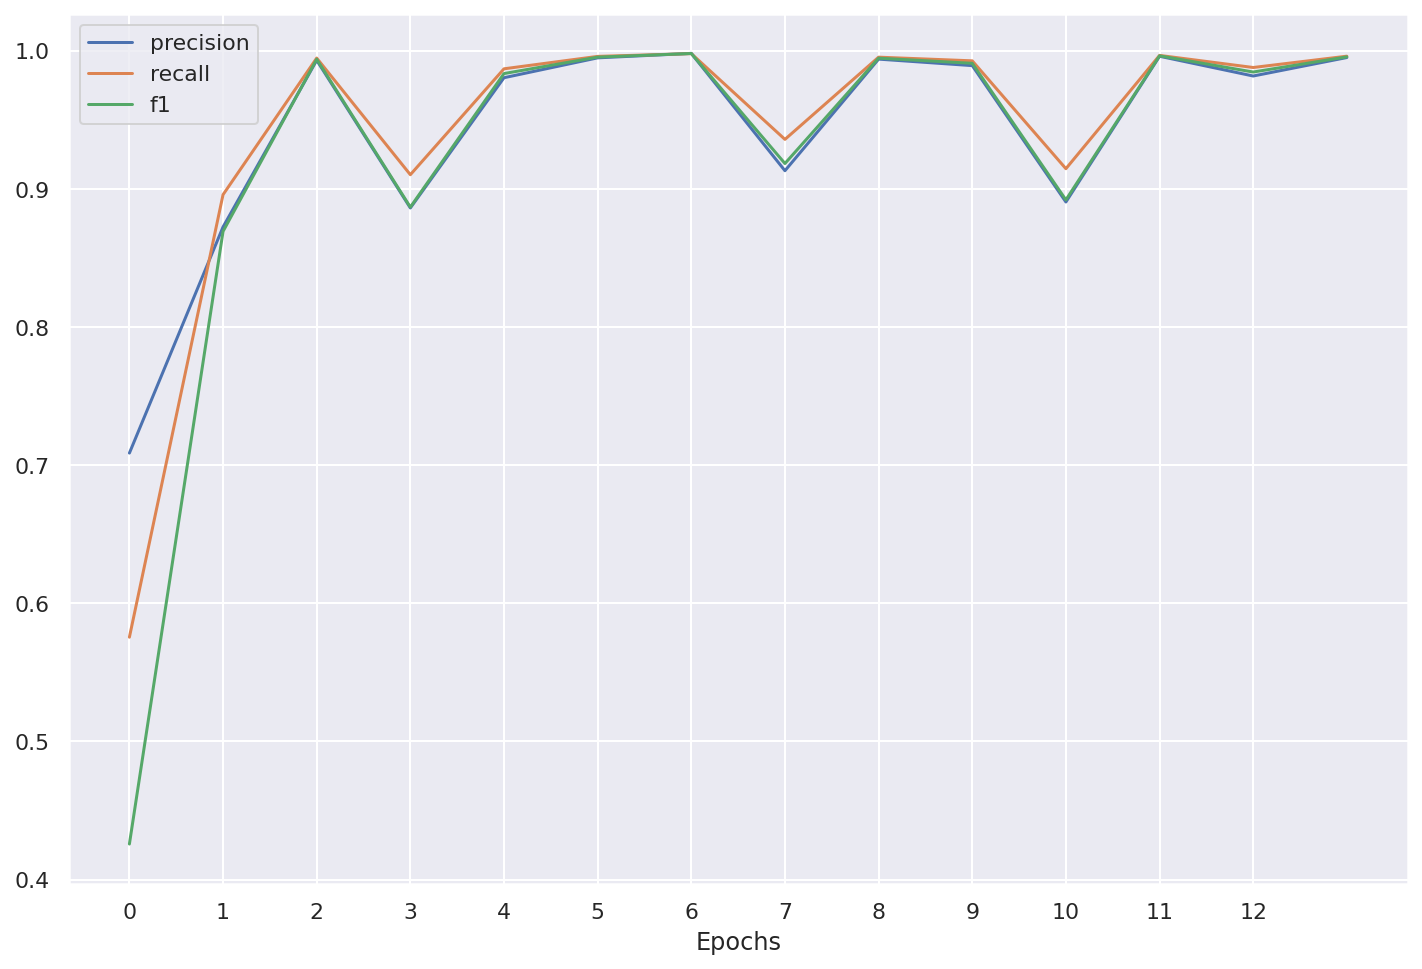

In [43]:
# Let's plot some metrics from the validation set (during training)
plt.figure(figsize=(12, 8))
x = np.linspace(0, model.stopped_epoch, len(model.metrics.val_precisions_macro))

# Plot the `precision`, `recall` and `f1` scores 
plt.plot(x, model.metrics.val_precisions_macro, label='precision')
plt.plot(x, model.metrics.val_recalls_macro, label='recall')
plt.plot(x, model.metrics.val_f1s_macro, label='f1')

# Draw the legend and label the X-axis
plt.legend()
plt.xticks(np.arange(0, model.stopped_epoch, step=1))
plt.xlabel('Epochs')
pass

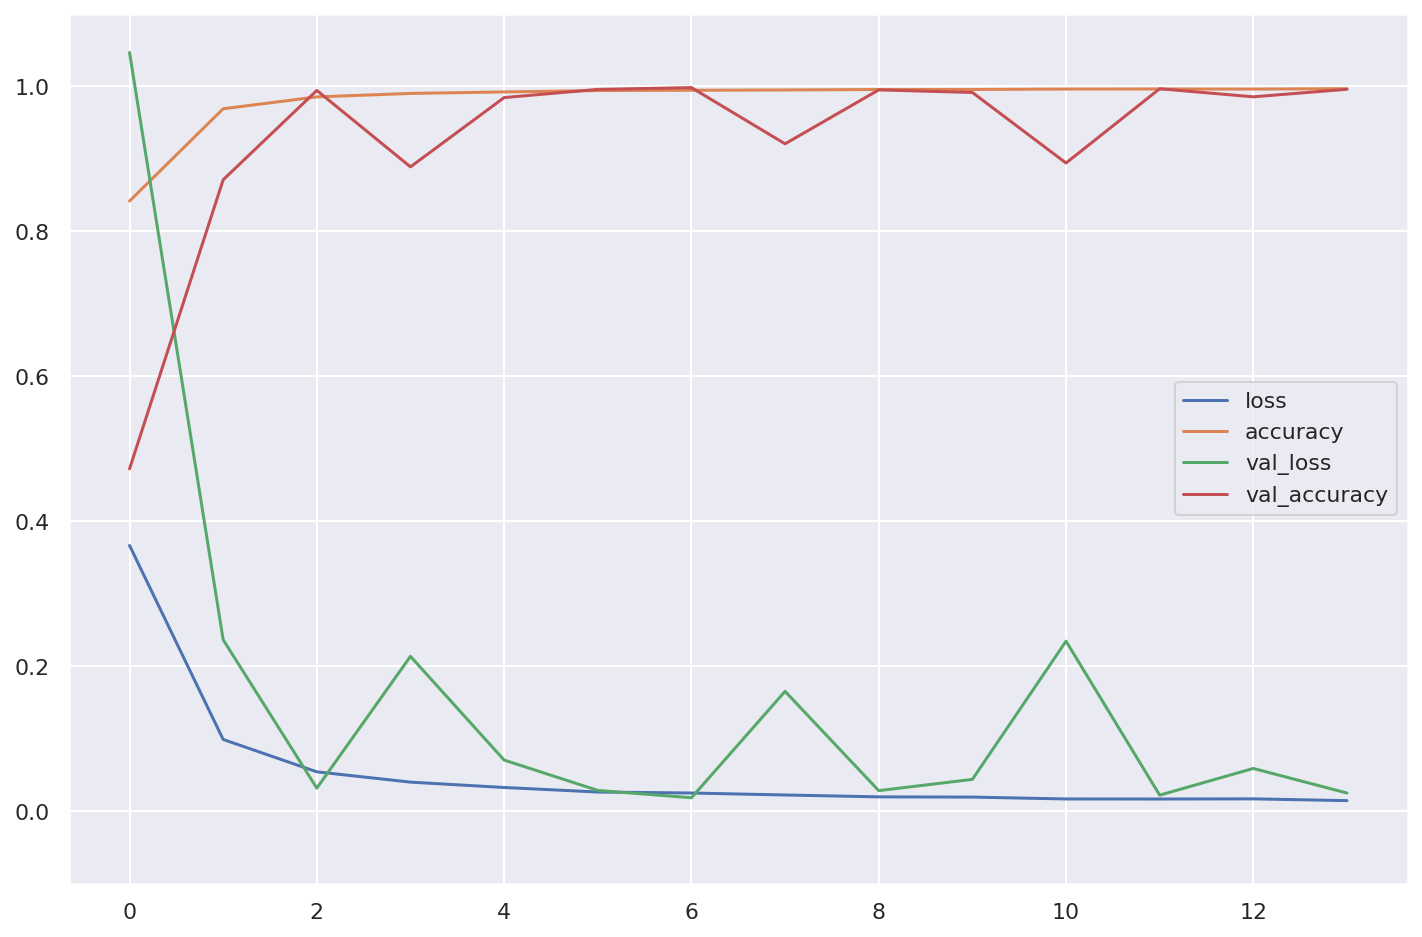

In [44]:
# Let's plot the learning curves of this model
pd.DataFrame(model.history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(-0.1, 1.1)
plt.show()
# As we can see, both accuracies are very high (and close together) - the same thing for losses (in the lower part of the graph) 

## Generate predictions

In [45]:
# Enough, now let's generate the predictions for the test set

In [46]:
test_df.shape

(5661, 1)

In [47]:
test_df.head()

,Sentence
0,49830
1,"1"" ) ) ) union all select null--"
2,"1 ) union all select null,null,null,null,null..."
3,1' ) as bagi where 1281 = 1281 ( select ( c...
4,"INSERT INTO mass ( gain, written, lunch, allow..."


In [48]:
# Prepare the `test_df` using the same preprocessing function (with the same parameters -> same represenation shape)
X_test = SQLDataset(test_df, alphabet, 400).prepare_test_data()

  0%|          | 0/5661 [00:00<?, ?it/s]

In [49]:
X_test.shape

(5661, 400)

In [50]:
y_pred = model.predict(X_test)
y_pred

177/177 [==============================] - 0s 2ms/step


array([0, 1, 1, ..., 0, 0, 0])

In [51]:
neg_pred = len(y_pred[y_pred == 0])
pos_pred = len(y_pred[y_pred == 1])
neg_pred, pos_pred

(3462, 2199)

In [52]:
pos_pred / (neg_pred + pos_pred)
# ~40%

0.38844727080021196

In [53]:
# Knowing that the dataset was splitted approximately 60% class_0 and 40% class_1 for each set (train / valid / test)
# and we obtained a ratio of ~40% for the positive class (in the test set) AND the model obtains ~99.9% accuracy on the validation set,
# that is a small sign that the predictions on the private test set are good :)

In [54]:
submission = pd.DataFrame(y_pred, columns=['Label'])
submission

,Label
0,0
1,1
2,1
3,1
4,0
...,...
5656,0
5657,1
5658,0
5659,0


In [55]:
submission.to_csv('./submission.csv', index=False)